# **DALL-E Mini Image Generator: Create Digital Art with from Text Prompts**

By Robert. A Gonsalves</br>
Based on https://github.com/borisdayma/dalle-mini

![image](https://raw.githubusercontent.com/robgon-art/e-dall-e/main/e-dal-e_med.png)

You can see my article on [Medium](https://towardsdatascience.com/e-dall-e-creating-digital-art-with-varying-aspect-ratios-5de260f4713d).

The source code and generated images are released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/).</br>
![CC BYC-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)




In [1]:
#@title Initialize system

!nvidia-smi -L
# Install required libraries
!pip install -q dalle-mini
!pip install git+https://github.com/robgon-art/dalle-mini.git
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU (UUID: GPU-0eba20dc-ae78-de63-e6f1-a2964ebd6a91)
  Cloning https://github.com/robgon-art/dalle-mini.git to c:\users\jaydev\appdata\local\temp\pip-req-build-hgw0gn1o
  Resolved https://github.com/robgon-art/dalle-mini.git to commit 64592126bd589b8b6f0c3e096ebd3e0b5936fe2e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/robgon-art/dalle-mini.git 'C:\Users\JAYDEV\AppData\Local\Temp\pip-req-build-hgw0gn1o'


1

In [3]:
#@title Choose DALL-E Model

choose_model = "DALL-E Mini" #@param ["DALL-E Mini", "DALL-E Mega", "DALL-E Mega Full"]

models = {"DALL-E Mini":"dalle-mini/dalle-mini/mini-1:v0",
          "DALL-E Mega":"dalle-mini/dalle-mini/mega-1-fp16:latest",
          "DALL-E Mega Full":"dalle-mini/dalle-mini/mega-1:latest"}

DALLE_COMMIT_ID = None

DALLE_MODEL = models[choose_model]

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

AttributeError: module 'jax.numpy' has no attribute 'DeviceArray'

In [2]:
#!pip install transformers
#@title Generate Images

import matplotlib.pyplot as plt
import random

prompt = 'a painting of rolling farmland' #@param {type:"string"}
prompts = [prompt]
tokenized_prompts = processor(prompts)
tokenized_prompt = replicate(tokenized_prompts)

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

# number of predictions per prompt
n_predictions = 7

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        # display(img)
        # print()


cols = n_predictions
index = 0
fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(cols*4, 4))
for i in range(cols):
  axes[i].axis("off")
  axes[i].set_title(str(index+1), fontsize=15)
  axes[i].imshow(images[index])
  index += 1

fig.tight_layout()
plt.show()
print(prompt)


NameError: name 'processor' is not defined

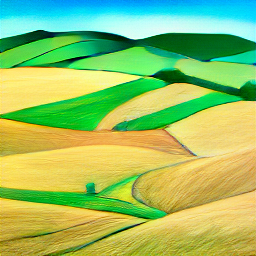

In [ ]:
#@title Show Larger Image

choose = 6 #@param {type:"slider", min:1, max:7, step:1}
from IPython.display import Image
images[choose-1].save("output.png")
Image('output.png')